In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from ood_detection_helper import *
from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
import plotly as py
import plotly.graph_objs as go

import umap
from sklearn.preprocessing import MinMaxScaler 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  0
[]


'2.3.1'

In [3]:
# pd.set_option('display.width', pd.util.terminal.get_terminal_size()[0])
# pd.set_option('display.width', 150)

In [4]:
LABELS = np.array(["Train", "CIFAR", "Outliers"])
COLORS = sns.color_palette("bright")
results = {}

## Hyperprameter analysis

In [76]:
SHs = [1, 3, 10, 15, 20]

Collected: (85197, 1)
========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   16.0s finished


Best: -1.420921 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
---------------------------------------------------------------------------
-1.420921 (0.010340) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
-1.422725 (0.009971) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
-1.423089 (0.010608) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
-1.422988 (0.010649) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
-1.422673 (0.010030) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
-1.422376 (0.010366) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
-1.422200 (0.009550) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
-1.421632 (0.009933) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
-1.422146 (0.009972) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
-1.421993 (0.010304) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}

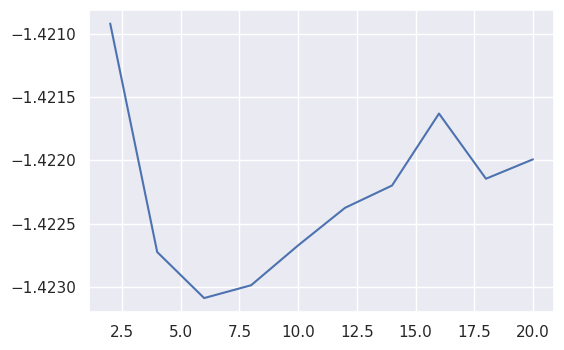

---Likelihoods---
Training: -1.421
CIFAR: -1.407
Outliers: -8.147
========================= Training Flow Model =========================
Epoch 1/1000
390/390 [==============================] - 1s 3ms/step - loss: 79.4371 - val_loss: 4.9252
Epoch 2/1000
390/390 [==============================] - 1s 2ms/step - loss: 4.7061 - val_loss: 4.6518
Epoch 3/1000
390/390 [==============================] - 1s 2ms/step - loss: 4.6459 - val_loss: 4.6446
Epoch 4/1000
390/390 [==============================] - 1s 2ms/step - loss: 4.6374 - val_loss: 4.6352
Epoch 5/1000
390/390 [==============================] - 1s 2ms/step - loss: 4.6273 - val_loss: 4.6242
Epoch 6/1000
390/390 [==============================] - 1s 2ms/step - loss: 4.6154 - val_loss: 4.6116
Epoch 7/1000
390/390 [==============================] - 1s 2ms/step - loss: 4.6019 - val_loss: 4.5971
Epoch 8/1000
390/390 [==============================] - 1s 2ms/step - loss: 4.5860 - val_loss: 4.5802
Epoch 9/1000
390/390 [=======================

In [ ]:
%%time
for L in NUM_Ls:
    
    fname = "SH1e+00_L{}.p".format(L)
    with open(fname, "rb") as f:
        score_dict = pickle.load(f)

    train_scores = np.array(score_dict["train"])
    inlier_scores = np.array(score_dict["cifar"])
#     outlier_scores = [np.array(score_dict["svhn"])]
    outliers = [n for n in list(score_dict.keys()) if n not in ["train", "cifar"]]
    outlier_scores = np.concatenate([np.array(score_dict[n] )for n in outliers])
    
    if L == 1:
        train_scores = train_scores.reshape(-1,1)
        inlier_scores = inlier_scores.reshape(-1,1)
        outlier_scores = outlier_scores.reshape(-1,1)
    
    print("Collected:", outlier_scores.shape)

    # Train Data = L2-norm(Pixel Scores)
    X_train, X_test =  train_scores.copy(), inlier_scores.copy()
    result_dict = auxiliary_model_analysis(X_train, X_test, [outlier_scores],
                                          LABELS, flow_epochs=1000)
    
    with open("L_models/{}.p".format(L), "wb") as f:
        pickle.dump(result_dict, f)

In [56]:
outliers = [n for n in list(score_dict.keys()) if n not in ["train", "cifar"]]
all_images = np.concatenate([score_dict[n].numpy() for n in outliers])
all_images.shape

(85197,)

## GMM

In [85]:
results = {}

for L in NUM_Ls:
    with open("L_models/{}.p".format(L), "rb") as f:
        result_dict=pickle.load(f)
        results[L]=result_dict

In [102]:
pd.DataFrame(results)

,1,3,10,15,20
GMM,"{'train_scores': [-1.4928648145563708, -1.0392...","{'train_scores': [-3.1109398089749813, -3.2158...","{'train_scores': [4.908630456594171, 4.6716318...","{'train_scores': [16.983490619676736, 18.28165...","{'train_scores': [25.980411969899254, 27.76614..."
Flow,"{'train_scores': [-2.4802241, -1.8764017, -1.8...","{'train_scores': [-6.1108017, -5.8113017, -7.2...","{'train_scores': [-4.777691, -4.330601, -6.113...","{'train_scores': [1.4676132, 2.7712288, -2.753...","{'train_scores': [1.7022972, 4.407133, -1.1370..."
KD,"{'train_scores': [0.0004863739013671875, 0.000...","{'train_scores': [0.19906956172898746, 0.19988...","{'train_scores': [0.7760938521597947, 0.709333...","{'train_scores': [0.9879778608909406, 1.007291...","{'train_scores': [1.1161734583318819, 0.763101..."


In [105]:
df = pd.concat([pd.DataFrame(results[L]["GMM"]["metrics"]) for L in NUM_Ls])
df.index=NUM_Ls
df

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
1,94.467519,38.622765,67.08,91.71,94.467469,14.910702,64.801311
3,97.061195,27.441451,46.83,81.31,97.061174,24.796944,78.277574
10,99.919786,4.763712,0.00,4.59,99.919785,96.604717,99.383870
15,99.393124,11.142519,6.26,20.23,99.393120,78.591069,95.490405
20,99.668442,7.917039,2.23,12.88,99.668440,84.788268,97.393327


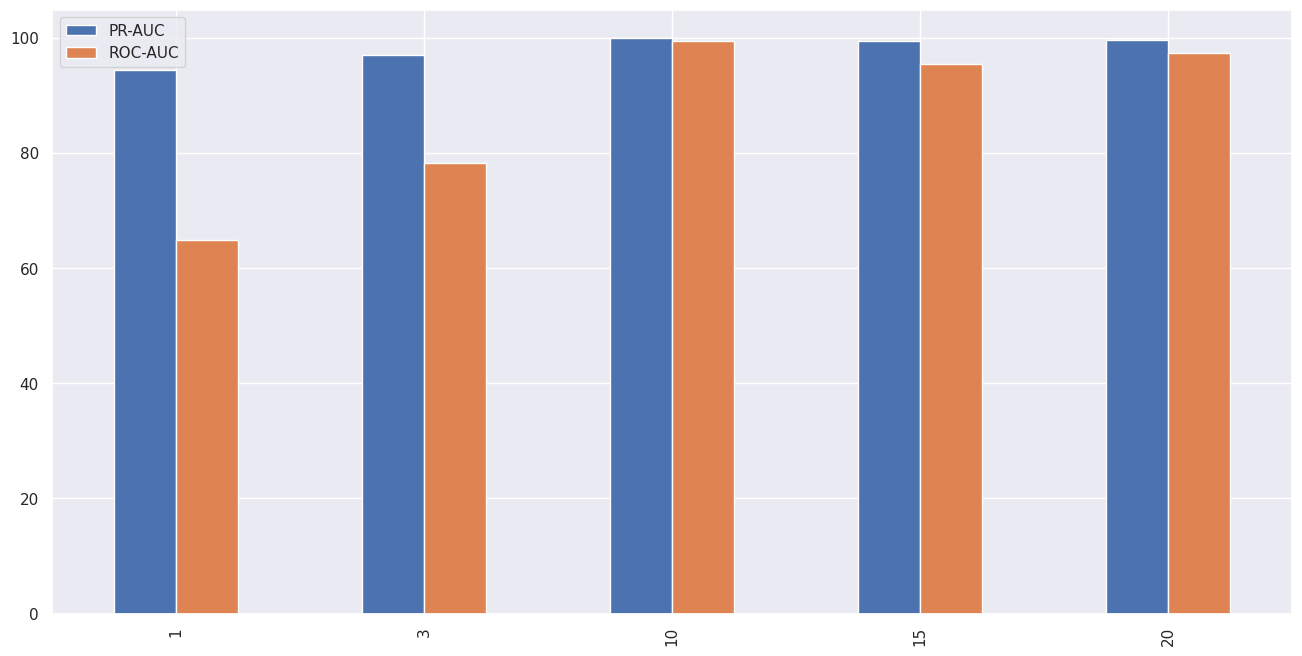

In [116]:
df[["pr_auc_in", "roc_auc"]].plot(kind="bar", figsize=(16,8))
plt.legend(["PR-AUC", "ROC-AUC"])

In [44]:
results[20]["GMM"]["metrics"]

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
SVHN,78.014318,44.251414,73.54,93.13,78.012763,31.773288,57.142454


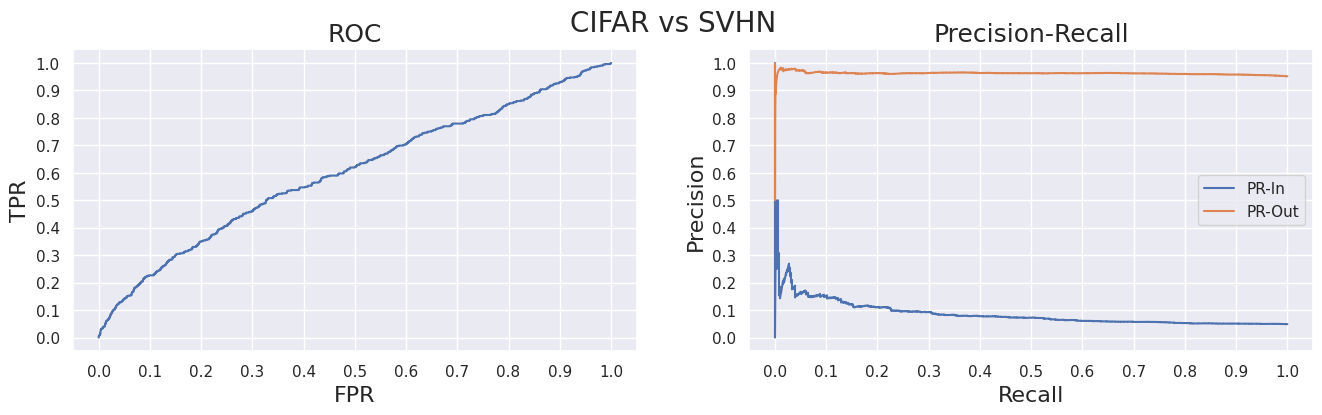

CIFAR vs SVHN
----------------
ROC-AUC: 60.0535
PR-AUC (In/Out): 8.4641 / 96.2250
FPR (95% TPR): 92.92%
Detection Error: 41.18%


{'fpr_tpr95': 0.9292,
 'de': 0.41179374999999996,
 'roc_auc': 0.6005352539062501,
 'pr_auc_in': 0.08464142186718648,
 'pr_auc_out': 0.962249784275808,
 'fpr_tpr80': 0.7235,
 'ap': 0.08598289363679514}

In [38]:
ood_metrics(-results[20]["Flow"]["test_scores"], -results[20]["Flow"]["ood_scores"][0],
            names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

In [46]:
results.keys()

dict_keys([3, 20, 10])

CIFAR vs SVHN
----------------
ROC-AUC: 98.9185
PR-AUC (In/Out): 98.6949 / 99.0439
FPR (95% TPR): 3.32%
Detection Error: 3.81%
CIFAR vs SVHN
----------------
ROC-AUC: 94.5014
PR-AUC (In/Out): 90.7242 / 96.0430
FPR (95% TPR): 15.28%
Detection Error: 10.17%
CIFAR vs SVHN
----------------
ROC-AUC: 57.1425
PR-AUC (In/Out): 78.0128 / 31.7733
FPR (95% TPR): 93.13%
Detection Error: 44.25%


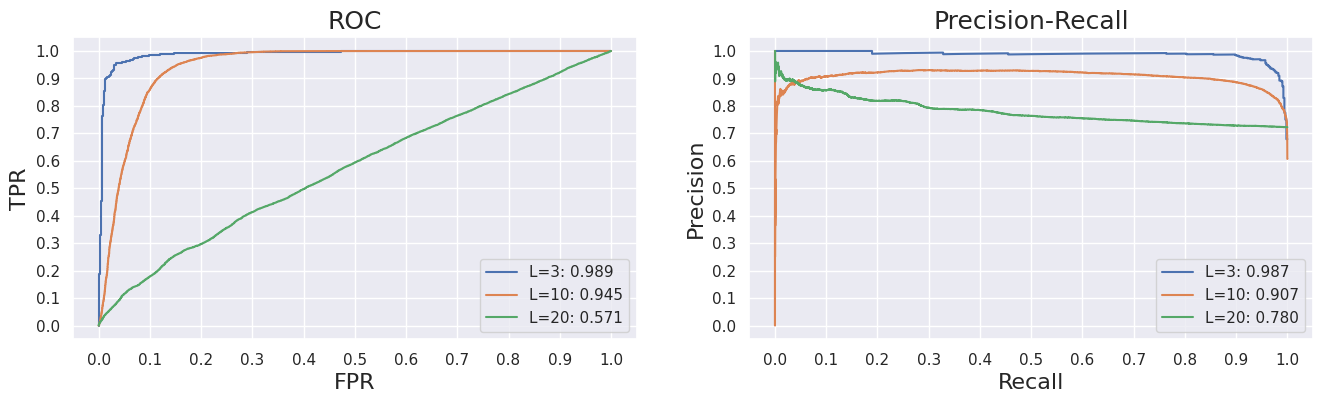

In [48]:
pairs = zip(
    ["L=3", "L=10", "L=20"],
    [-results[3]["GMM"]["test_scores"], -results[20]["GMM"]["test_scores"], -results[20]["GMM"]["test_scores"]],
    [-results[3]["GMM"]["ood_scores"][0], -results[20]["GMM"]["ood_scores"][0]]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

# for title, cifar_scores, svhn_scores in pairs:
#     ood_metrics(cifar_scores, svhn_scores, names=("CIFAR", "SVHN"),plot=False, verbose=True)
#     plot_curves(cifar_scores, svhn_scores, title, axs)
    
for L in [3,10,20]:
    title = "L={:d}".format(L)
    cifar_scores = -results[L]["GMM"]["test_scores"]
    svhn_scores = -results[L]["GMM"]["ood_scores"][0]
    ood_metrics(cifar_scores, svhn_scores, names=("CIFAR", "SVHN"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)

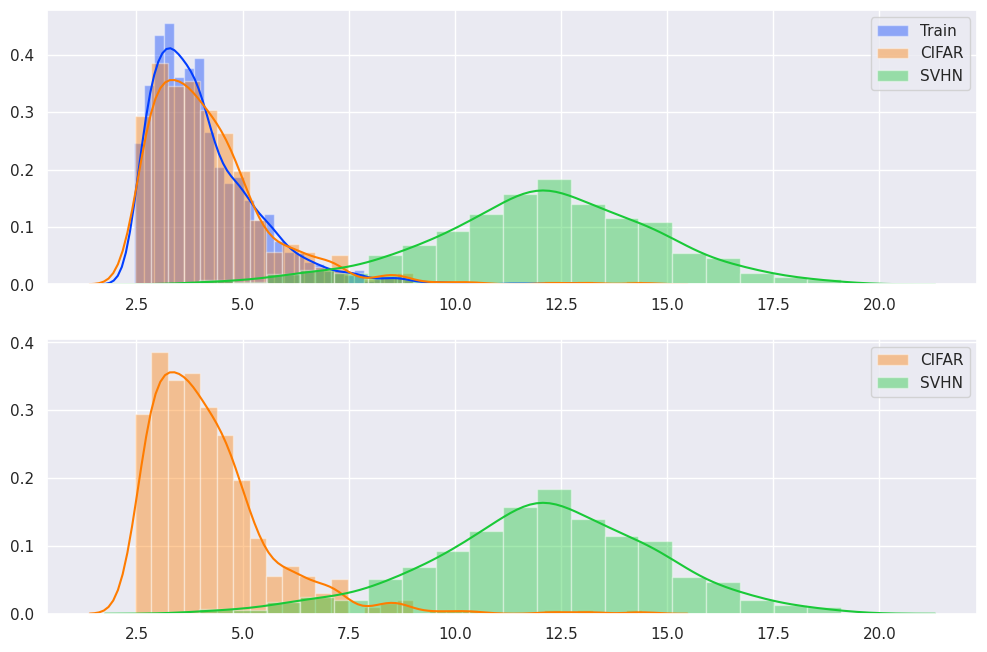

In [18]:
axs=evaluate_model(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"],
               -results["GMM"]["ood_scores"][test_idxs], labels=LABELS[label_idxs])

### Validation Check

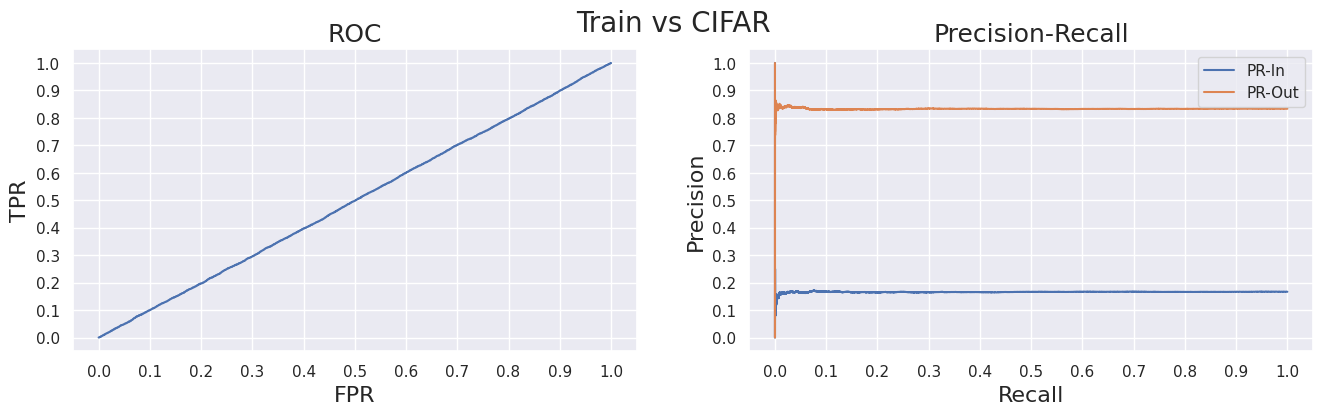

Train vs CIFAR
----------------
ROC-AUC: 49.8375
PR-AUC (In/Out): 16.5744 / 83.2966
FPR (95% TPR): 94.68%
Detection Error: 49.86%


{'fpr_tpr95': 0.94684,
 'de': 0.49861,
 'roc_auc': 0.498375335,
 'pr_auc_in': 0.16574405407058362,
 'pr_auc_out': 0.8329657357554794,
 'fpr_tpr80': 0.79388,
 'ap': 0.16581662965069266}

In [39]:
ood_metrics(-results[20]["GMM"]["train_scores"], -results[20]["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [21]:
results["Flow"]["metrics"]

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
SVHN,31.077869,50.0,99.804688,100.0,31.024508,31.042214,4.160309


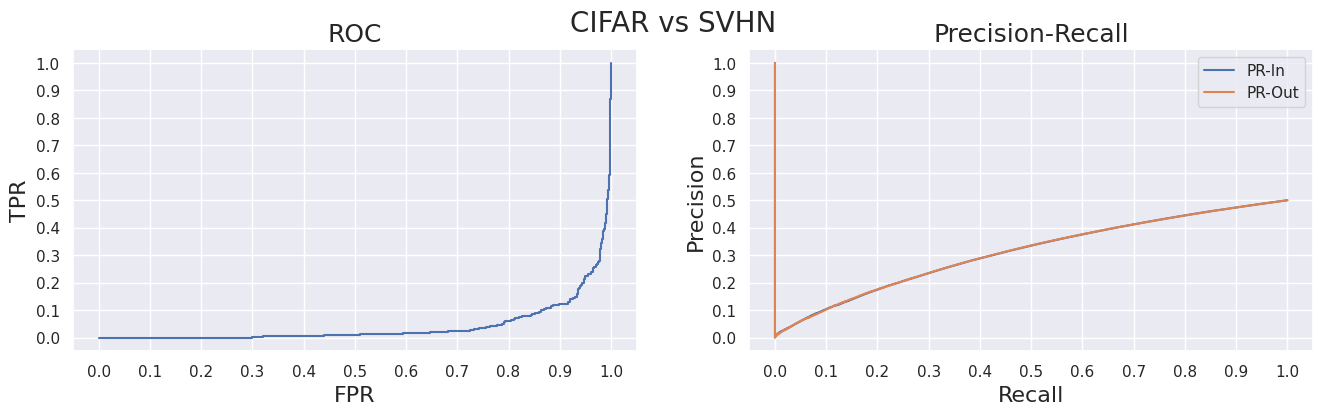

CIFAR vs SVHN
----------------
ROC-AUC: 4.1603
PR-AUC (In/Out): 31.0245 / 31.0422
FPR (95% TPR): 100.00%
Detection Error: 50.00%


{'fpr_tpr95': 1.0,
 'de': 0.5,
 'roc_auc': 0.04160308837890625,
 'pr_auc_in': 0.3102450833578067,
 'pr_auc_out': 0.31042214479007485,
 'fpr_tpr80': 0.998046875,
 'ap': 0.310778687259369}

In [23]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][0], names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

### Validation Check

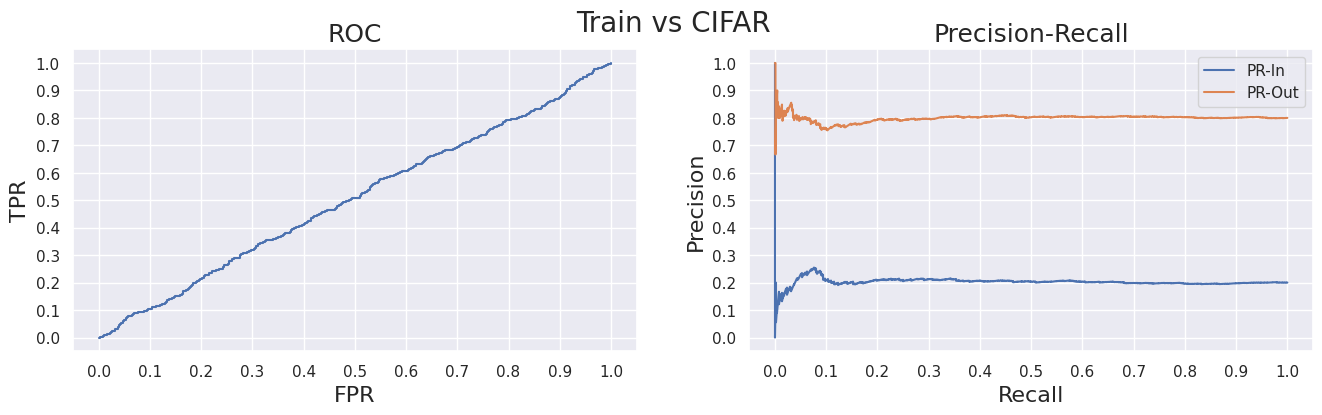

Train vs CIFAR
----------------
ROC-AUC: 50.4051
PR-AUC (In/Out): 20.2615 / 79.9358
FPR (95% TPR): 94.92%
Detection Error: 48.51%


{'fpr_tpr95': 0.94921875,
 'de': 0.485107421875,
 'roc_auc': 0.5040512084960938,
 'pr_auc_in': 0.20261469592650067,
 'pr_auc_out': 0.7993577506842766,
 'fpr_tpr80': 0.79541015625,
 'ap': 0.2036689440263987}

In [24]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [25]:
results["KD"]["metrics"]

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc
SVHN,99.246773,3.027344,0.585938,1.367188,99.245962,99.200568,99.230576


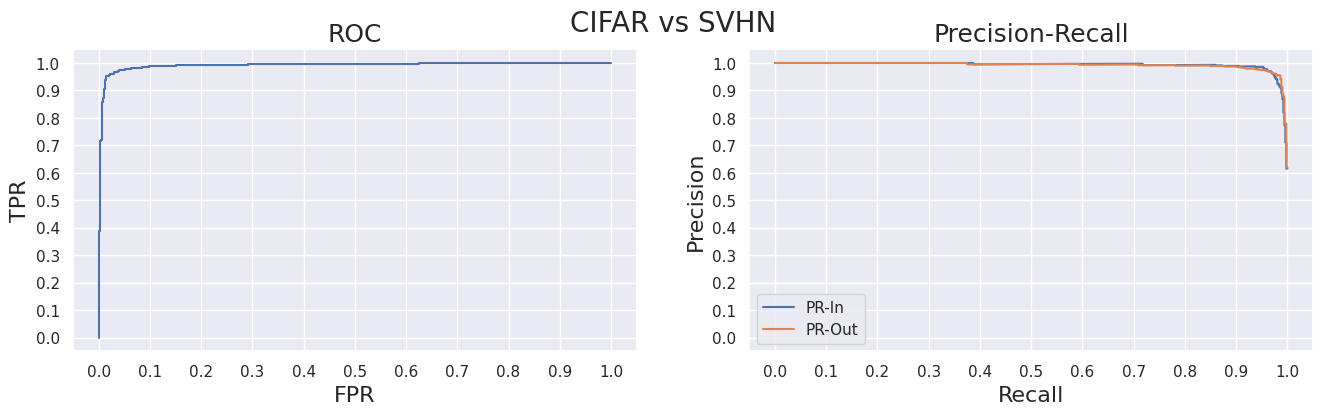

CIFAR vs SVHN
----------------
ROC-AUC: 99.2306
PR-AUC (In/Out): 99.2460 / 99.2006
FPR (95% TPR): 1.37%
Detection Error: 3.03%


{'fpr_tpr95': 0.013671875,
 'de': 0.0302734375,
 'roc_auc': 0.9923057556152344,
 'pr_auc_in': 0.9924596233208017,
 'pr_auc_out': 0.9920056811241862,
 'fpr_tpr80': 0.005859375,
 'ap': 0.9924677333247757}

In [26]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][0], names=(LABELS[1], LABELS[2]), plot=True, verbose=True)

### Validation Check

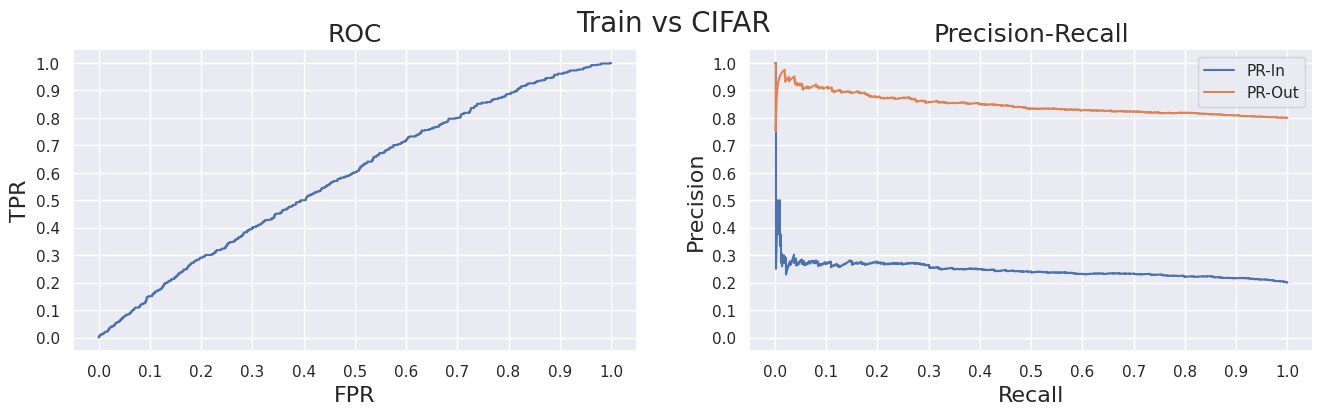

Train vs CIFAR
----------------
ROC-AUC: 58.2431
PR-AUC (In/Out): 24.5969 / 84.8001
FPR (95% TPR): 88.57%
Detection Error: 43.70%


{'fpr_tpr95': 0.8857421875,
 'de': 0.43701171875,
 'roc_auc': 0.5824308395385742,
 'pr_auc_in': 0.2459687393926434,
 'pr_auc_out': 0.8480011858349078,
 'fpr_tpr80': 0.6826171875,
 'ap': 0.24721400799667567}

In [27]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## GMM vs Flow vs K-NN Tree on CIFAR vs Any

CIFAR vs SVHN
----------------
ROC-AUC: 98.9174
PR-AUC (In/Out): 98.6919 / 99.0433
FPR (95% TPR): 3.32%
Detection Error: 3.81%
CIFAR vs SVHN
----------------
ROC-AUC: 4.1603
PR-AUC (In/Out): 31.0245 / 31.0422
FPR (95% TPR): 100.00%
Detection Error: 50.00%
CIFAR vs SVHN
----------------
ROC-AUC: 99.2306
PR-AUC (In/Out): 99.2460 / 99.2006
FPR (95% TPR): 1.37%
Detection Error: 3.03%


Text(0.5, 0.98, 'Comparing Auxiliary Methods')

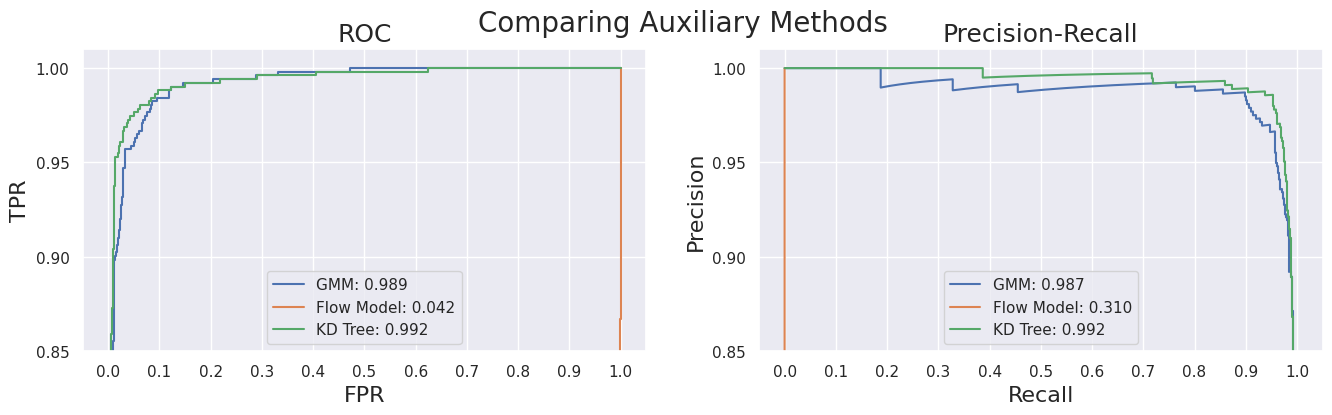

In [28]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][0:])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][0:])
kd_all = np.concatenate(results["KD"]["ood_scores"][0:])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    ood_metrics(cifar_scores, svhn_scores, names=("CIFAR", "SVHN"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)

for ax in axs:
    ax.set(ylim=(0.85, 1.01), yticks=np.arange(0.85, 1.01, step=0.05))
# axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
# plt.savefig("./aux.png", dpi=200)